In [2]:
### PREAMBLE
# Chapter 3 - Adversarial examples, solving the inner maximization
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**any bullet points are comments I've made to help for understanding!**

## Moving to neural networks

Now that we've seen how adversarial examples and robust optimization work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks.  Although it may seem as though as though this is a rather small change, the nature of neural networks makes the problem of adversarial examples both much more pronounced (as we will see a typically trained neural network is much more sensitive to adversarial attacks than even the naive linear models we considered), and much harder to protect against.

Returning back to our optimization once again, let's consider the inner maximization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x), y)
\end{equation}
where $h_\theta(x)$ now represents a neural network.  For much of the work in this section (though less so for  the traditional adversarial examples) we will need to dive more fully into the precise form of $h_\theta$, so define it a bit more formally at this point. Specially, we define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function is the same as we used before for the multiclass case, namely the cross entropy loss
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

When we move to neural networks, several challenges arrise, due to the fact that the loss surface of standard neural networks is much more "irregular" and than for linear models.  While we won't go into too much detail on this point, **the underlying issue here is that because neural networks have much more modeling power than linear models, they have the ability to have much bumpier function surface.** For example, consider the hypothesis for a simple (randomly trained) model below, compared to a simple linear function.

Text(0,0.5,'Output')

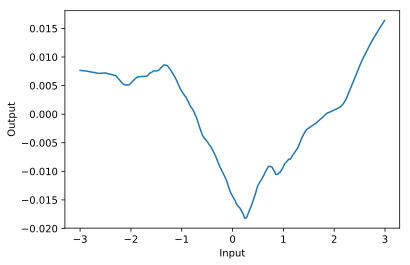

In [208]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

These loss surfaces lead to two main challenges. **First, in the high dimensional setting that we will typically consider with deep networks, there is a high likelihood that at almost any point in input space there will be _some_ direction along the loss surface that is very steep, i.e., which causes the loss to either increase or decrease substantially.  This is actually the mathematical equivalent of what we saw in the introductory chapter: that we can move a small distance in input space (i.e., have a small perturbation), which leads to a big increase in loss.  Put another way, _neural networks, by the nature of their loss surfaces, are especially prone to adversarial examples_.**

* this is what we were talking about in class on Thursday, November 18 where with these adversarial attacks, with neural networks we're in such high dimensions and any sort of movement can potentially have large implications, are these points really just OOD?

The second challenge is that **unlike the linear case, it is _not_ easy to solve (or easily upper bound, as we did in the multiclass linear case), the inner maximization problem over our perturbation.  This is because, as can be seen in the figure above, the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.**  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimnize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima.  This second point may be somewhat less of an issue if our goal is just to _construct_ an adversarial example against a standard deep network (after all, as the first point illustrated, there are many directions of high cost increase, and just following the gradient typically leads to _an_ adversarial example, even if it is not the _optimal_ adversarial example.  **But when we later consider _training_ robust networks, this will be a big problem, because it means that Danskin's theorem no longer holds, so we cannot solve the true robust optimization problem.**

### Strategies for the inner maximization

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x), y)
\end{equation}
in the case of $h_\theta$ being a neural network? There are three main strategies for doing so, which relate to _lower bounds, exact solutions, and upper bounds_ on this optimization objective.  In more detail, we have the following options:

1. **We can find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  This is by far the most common strategy for solving the inner maximization (motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought) and is indeed what we already did in Chapter 1.  However, in order to both find strong adversarial examples _and_ (in the next chapter), use this approach to train robust classifiers, it is important that we solve this problem _well_, which we will discuss shortly.**
2. We can attempt to solve the optimization problem _exactly_.  This is going to be a challenging problem, of course, but for many networks activations functions we can formulation the exact maximization problem as a _combinatorial_ optimization problem, and solve it exactly using techniques such as mixed integer programming.  These methods will of course have substantial challenges in scaling to large models, but for small problems they highlight an important point, that it _is_ possible to construct exact solutions to the inner maximization problem in some cases.
3. Finally, we can also _upper bound_ the optimization objective, similar to what we did with the multiclass linear case.  Of course, this is much mnore complex than in the linear case, but it _is_ still possible.  The basic strategy here will be consider a _relaxation_ of the network structure, such that this relaxed version contains the original network, but is built in a manner that is much easier to optimize exactly over.  As we will see, this will involve building _convex relaxations_ of the network structure itself.  These methods are a bit different in that they do _not_ typically construct an actual adversarial example for the real network (because they operate over a relaxed model which is not equivalent to the original one), but they can produce certifications that a network is _provably_ robust against an adversarial attack.  Futher, when combined with robust optimization for training, these methods make up the state of the art in training provably robust models.

Each of these strategies is worth considering in some detail, and this will make up the bulk of this chapter.

### Some example networks

Before we move to discussing the actual attacks, let's train a few simple networks on the MNIST problem.  Again, as we said in the previous Chapter, MNIST is of course an imperfect testbed for such settings (because some "simple" strategies like discretization work too well", but it still captures many of the fundamental principles of adversarial robustness.  We're going to actually consider three different architectures here: a two-layer or four-layer fully-connected network, and a network with four convolutional layers plus one fully-connected layer.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


The following code trains the models (you can skip below to directly load pre-trained models if you don't want to go through the training).

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [110]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [7]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.134117	0.517457	0.081000	0.287926
0.075600	0.265121	0.064000	0.221744
0.059050	0.209306	0.051100	0.182845
0.048983	0.172932	0.047100	0.157879
0.041817	0.146712	0.039800	0.136122
0.036300	0.126980	0.036100	0.123078
0.031217	0.112031	0.034500	0.115798
0.028333	0.100209	0.031500	0.106236
0.025267	0.090479	0.030300	0.099550
0.023033	0.082725	0.028500	0.093490


In [8]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234967	0.777794	0.085400	0.274186
0.065917	0.221888	0.053700	0.169755
0.042750	0.143761	0.036000	0.118373
0.031367	0.106577	0.036700	0.114283
0.024883	0.083901	0.028500	0.090540
0.021017	0.069757	0.023400	0.077370
0.017367	0.057413	0.024400	0.075043
0.014700	0.048096	0.022900	0.070490
0.012167	0.039399	0.022500	0.074383
0.009717	0.033524	0.021000	0.072392


In [9]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.206483	0.609042	0.026000	0.083938
0.024883	0.081515	0.017900	0.055983
0.017100	0.053789	0.016900	0.051890
0.012867	0.039944	0.013700	0.039924
0.009650	0.030815	0.013200	0.040250
0.004333	0.015506	0.010600	0.032351
0.003300	0.012391	0.010000	0.032211
0.002900	0.010868	0.010800	0.033129
0.002400	0.009762	0.010400	0.033581
0.001983	0.008888	0.010500	0.033701


In [13]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

If you don't want to run all the code above, you can simply load the models we trained using the following commands.

In [7]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

Together, these models will serve as a testbed for investigating the ability of different methods for solving the inner maximization problem that we care about.  Some of the approaches we detail below (namely the exact combinatorial methods) are difficult to scale even to the larger MNIST models, though the other approaches can all handle them, and it will be useful to consider the strengths/weaknesses of different approaches.

## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: **using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.**

* how we perform gradient descent for the inner maximization
    * I thought we were doing it on the input pixels, but we're doing it on delta

### The Fast Gradient Sign Method (FGSM)
* this section is super important as it helps set up for understanding PGD attacks

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will **first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.**

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  **For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update**
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  **If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes**
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [\cite{Goodfellow2014}], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

Let's see what this looks like in PyTorch.

In [6]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

Let's look at a few of the examples generated by the method, what the classifier predicts the origina images to be, and what the classifier predicts the modifed images to be.

In [15]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

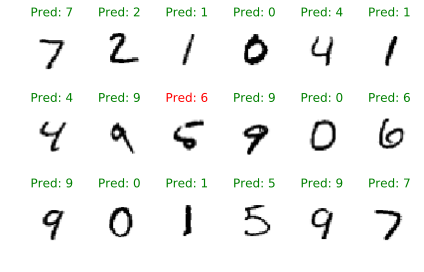

In [10]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

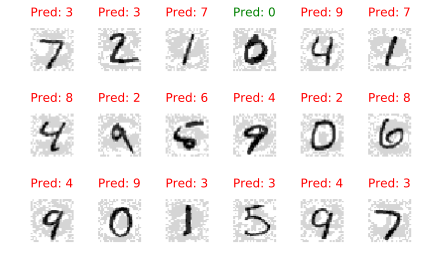

In [129]:
### Illustrate attacked images
# this is looking at an updated y prediction based on the updated input image (created by X + delta)
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

With relatively minor changes to the images (certainly none which would change our own prediction of the image label), we go from one incorrect prediction, to one correct prediction for this entire set we consider.  **It's worth pointing out here that fully connected networks are particularly succeptible to these issues, and ConvNets slightly less so (but of course they are still very sensitive).**  Let's see what the same attack looks like for our CNN model.

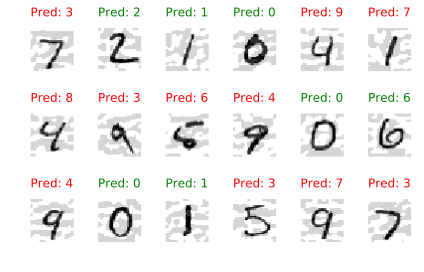

In [130]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Seeing the examples visually is nice, but let's evaluate the performance of the attack methods a bit more rigorously.  What do the test errors of our classifiers look like when evaluating against against the FGSM adversarial attack?

In [20]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        # this is looking at an updated y prediction based on the updated input image (created by X + delta)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [21]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9259
4-layer DNN: 0.8827
        CNN: 0.4173


* what we're doing here is just taking the FGSM attack, apply it to each of the images in the test set, and seeing the error for the pre-trained classifier

Before we move on, there are a few important points to be made about FGSM.  First, **it's important to emphasize that FGSM is specifically an attack under an $\ell_\infty$ norm bound: FGSM _is_ just a single projected gradient descent step under the $\ell_\infty$ constraint.  Thus, we need to consider and evaluate FGSM in the context of other $\ell_\infty$ attacks.**  But it is also very easy to generalize this procedure (and others) to other norms, a topic we will discuss in some detail below.
* this is important to know b/c we may not expect an $\ell_\infty$ norm bound to do well on $\ell_2$ attacks

The second point to make is that, if you recall the methods we presented in the previous chapter, **it should be apparent that FGSM is _exactly_ the optimal attack against a _linear_ binary classification model under the $\ell_\infty$ norm.  This hopefully gives some additional helpful understanding of what FGSM is doing: it assumes that the linear approximation of the hypothesis given by its gradient at the point $x$ is a reasonably good approximation to the function over the entire region $\|\delta\|_\infty \leq \epsilon$.  It also, however, hints right away at the potential _disadvantages_ to the FGSM attack: because we know that neural networks are _not_ in fact linear even over a relatively small region, if we want a stronger attack we likely want to consider better methods at maximizing the loss function than a single projected gradient step.**
* PGD appears to be a beefed-up version of FGSM

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the inner optimization problem, just doing **projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size).**  [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.] . This was also called the "basic iterative procedure" in its first appearance within the adversarial attacks literature [\cite{}], but **essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM.**  To re-iterate the basic approach (it is actually described directly above in the discussion of FGSM, and it is also the approach we used in the introductory section), the basic PGD algorithm simply iterates the updates.
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, **with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations** (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

In [195]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Let's first look at a few of the samples that we generate with this method on the CNN model.

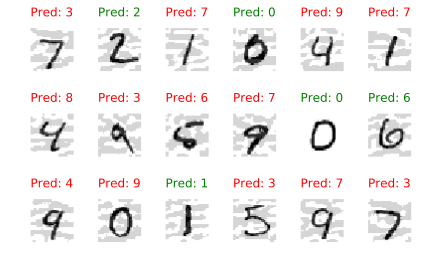

In [199]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Maybe you can already see a bit of an issue with this.  The attack doesn't seem all that much more effective than FGSM, and there is one 0 digit where oddly the attack didn't seem to do anything at all.  You may also notice that we are using an extremely large step size $\alpha=1e4$, which seems like it might be hard to come up with out of the blue.  **This is all due to the fact that gradient with respect to $\delta$ and $\delta=0$ is usually _very_ small at the examples themselves.**  Let's take a look.

In [202]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

1.8276920172866085e-06


**The average absolute value of the gradient for any given pixel is just around $10^{-6}$ at the initial zero point, so we need to scale it by a relatively large $\alpha$ to make any progress at all.  Once we "break out" of the initial region around $\delta=0$, the gradients typically increase in magnitude substantially, and at this point our large $\alpha$ is too large, and the method takes too big a step toward the boundary (effectively just acting like FGSM).**


**Aside: steepest descent.** To deal with the above issue, we're actually going to employ a slightly different optimization method, known as the (normalized) steepest descent method.  This is a completely standard optimization procedure, described e.g. in [\cite{Boyd}], but since it varies slightly from the traditional gradient descent algorithm, we just briefly derive it here.  Speaking generically, if we want to minimize some function $f : \mathbb{R}^n \rightarrow \mathbb{R}$ over the input $z$, the traditional gradient descent algorithm repets the update
\begin{equation}
z := z - \alpha \nabla_z f(z).
\end{equation}
**The trouble with this update (which is what we encountered above), is that it is highly sensitive to the absolute scale of the gradient, and adjusts the parameters in a scale that always corresponds to the relative scaling of the gradient terms.  In contrast, the normalized steepest descent method applies find some negative update direction $v$, where _we choose $v$ to maximize the inner product between $v$ and the gradient_ subject to a norm constraint on $v$.  That is normalized steepest descent performs the update**
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
z := z - \argmax_{\|v\| \leq \alpha} v^T \nabla_z f(z).
\end{equation}
In the case that we use an $\ell_2$ norm constraint on $v$, the argmax has the analytical solution
\begin{equation}
\argmax_{\|v\|_2 \leq \alpha} v^T \nabla_z f(z) = \alpha \frac{\nabla_z f(z)}{\|\nabla_z f(z)\|_2}
\end{equation}
so that the step correponds to a version of gradient descent where we normalize the gradient vector to have unit norm.  **Similarly, if we use an $\ell_\infty$ norm constraint on $v$, then by the exact same logic we saw in the previous lecture concerning the optimal adversarial attack against a linear function, the argmax is given by**
\begin{equation}
\argmax_{\|v\|_\infty \leq \alpha} v^T \nabla_z f(z) = \alpha \cdot \mathrm{sign}(\nabla_z f(z)).
\end{equation}

**Back to our adversarial attack on deep networks now: it's fairly common to choose a steepest descent norm to match the norm that we are ultimately minimizing with respect to, so for an attack with bounded $\ell_\infty$ norm, we will run (projected) normalized steepest descent under the $\ell_\infty$ norm (which just like gradient descent, projects back into the allowable ball after a graident step) instead of traditional gradient descdent.  From the equation above, it should be apparent that this just essentially correponds to many "mini-FGSM" steps, hence the original name of the "basic iterative algorithm" for this approach.**  And although this is technically a slightly different optimization algorithm than gradient descent, the method is still broadly referred to as "projected gradient descent" and this version here makes up the actual PGD method employed by modern attacks.  Let's see what this looks like with PyTorch.
* we are actually using normalized gradient descent rather than traditional approach!

In [118]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

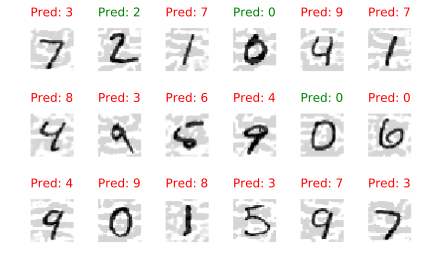

In [26]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Much better, we're still not creating adversarial example for all cases, but we're doing a lot better than the FGSM algorithm.  It's also quite a bit easier to choose step sizes than before.  **Since the step size $\alpha$ is on the same scale as the total perturbation bound $\epsilon$, it makes sense to choose $\alpha$ to be some reasonably small fraction of $\epsilon$, and then choose the number of iterations to be a small multiple of $\epsilon/\alpha$.**  Let's see how these perform as an attack over the whole test set.
* this is best practices for choosing $\alpha$ and $\epsilon$!

In [28]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9637
4-layer DNN: 0.9838
CNN: 0.7432


That is a reasonable improvement over the FGSM attack.  There is one last strategy we can perform to improve performance even slightly more: randomization; this technique is not that often used in practice as it is relatively cost, but it highlights an important point.

The performance of PGD is still limited by the possibility of local optima within the objective.  And while it's not possible to avoid the reality of local optima entirely, we can mitigate the problem slightly by random restarts.  In other words, we don't just run PGD once, but we run it multiple times from different random locations within the $\ell_\infty$ ball of choice.  This gives a minor but not completely negligible improvement, but importantly highlights the fact that there _are_ local optima that PGD started at the zero point will find, and which can be avoided to some extent just by randomization.  On the downside, the approach as written naively below also increases the runtime by a factor equal to the number of restarts, so may not be practical in many settings.

In [95]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [94]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.7648


### Targeted attacks

What we have considered so far are "untargeted" attacks, meaning they effectively try to change the label to _any_ alternative, rather than change it to a particular alternative.  As a different task, which we saw briefly in the introduction, we can change the attack to try to convert the prediction to a particular alernative.  This is a task known as a "targetted attack", and it can be achieved using the same strategy overall strategy as we did previously.  However, in this case the only difference is that instead of maximizing the loss of the true label, we maximize the loss of the loss of the true label and also minimize the loss for the alternative label.  This is equivalent to solving the inner optimization problem
\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \left ( \ell(h_\theta(x + \delta), y) - \ell(h_\theta(x + \delta), y_{\mathrm{targ}}) \right ) \equiv \maximize_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta)_{y_{\mathrm{targ}}} - h_\theta(x + \delta)_y \right )
\end{equation}
Let's see what this looks like, using a PGD attack (without randomized restarts).  Note that in order to achieve our targetted class in most of these cases on MNIST, we use a slightly larger perturbation region, $\epsilon=0.2$.

In [171]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Let's look at trying to make the class label all equation to 2.

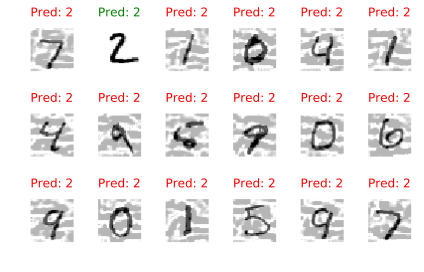

In [175]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

This looks pretty good: albeit with a slightly larger $\epsilon$, we can fool the classifier into predicting that all the examples are class 2 (note that the actual 2 is unchanged, because the loss function in this case is always exactly zero).  Let's try using a target class of 0 instead.

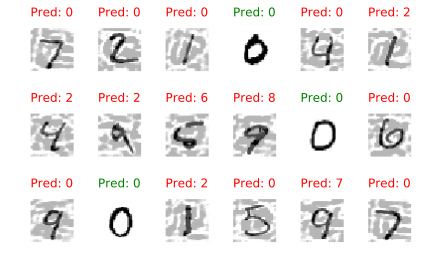

In [177]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

While we are able to fool the classifier for all the non-zero digits, it's worth pointing out that we don't actually achieve the target class here in all cases.  This is because the optimization objective we are maximizing is the class logit for the zero minus the class logit for the true class.  But we don't actually care what happens to the other classes, and in some cases, the best way to make the class 0 logit high is to make another class logit even higher.  We can get around this by modifying our objective to maximize the target class logit and minimize _all_ the other logits, i.e.,
\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta)_{y_{\mathrm{targ}}} - \sum_{y' \neq y_{\mathrm{targ}}} h_\theta(x + \delta)_{y'} \right )
\end{equation}

In [181]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

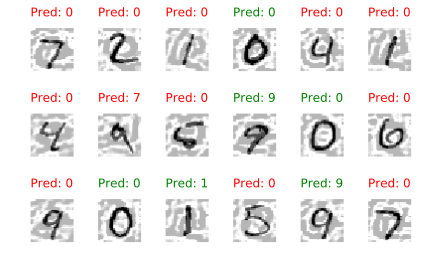

In [180]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

This is a more difficult objective than the previous one, so we aren't able to fool the classifier as much.  But when we _do_ fool the classifier, it more consistently (even if still not perfectly) able to predict the target class.

### Non-$\ell_\infty$ norms

Thus far, we have just been focusing on attacks where $\delta$ has bounded $\ell_\infty$ norm (and additionally, where we don't worry about clipping to the actual allowable $[0,1]$ range of the image.  In this section, we'll finally move beyond this, and consider $\ell_2$ in addition, and also explicitly include the constraint that $x + \delta$ needs to actually lie in the $[0,1]$ range.

**The good news is that the above strategies carry over exactly to this case.  The $\ell_2$ case is particularly simple: we just use the projedcted normalized steepest decent method for the $\ell_2$ ball**, which as discussed above has the form
\begin{equation}
\delta := \mathcal{P}_\epsilon \left(\delta - \alpha \frac{\nabla_\delta \ell(h_\theta(x+\delta),y)}{\|\nabla_\delta \ell(h_\theta(x+\delta),y)\|_2}\right )
\end{equation}
where $\mathcal{P}_\epsilon$ now denotes the projection onto the $\ell_2$ ball of radius $\epsilon$.  This projection in turn is just given by normalizing $\delta$ to have $\ell_2$ norm $\epsilon$ if it is greater than $\epsilon$, i.e.
\begin{equation}
\mathcal{P}_\epsilon(z) = \epsilon\frac{z}{\max\{\epsilon, \|z\|_2\}}.
\end{equation}
Thus, our final attack looks like the following.

In [210]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

* **this is what Mark has been using for robust training!**

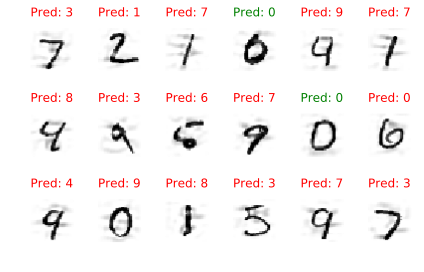

In [229]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [227]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.9232
4-layer DNN: 0.9435
CNN: 0.7854


Note that the $\epsilon$ you need to consider for $\ell_2$ norm perturbations is larger than what you need for $\ell_\infty$ perturbations, because the volume of the $\ell_2$ ball is proportional to $\sqrt{n}$ times the volume of the $\ell_\infty$ ball, where $n$ is the input dimension (technically, there is an additional scaling factor of $\sqrt{2}/\sqrt{\pi e}$ to make the volumes match more precisely in higher dimensions, which follows from some simple formulas for the volume of $\ell_p$ balls, but we won't prove this here). So for MNIST an $\ell_2$ ball with the same volume as an $\ell_\infty$ ball of radius $\epsilon = 0.1$ is approximately equal to an $\ell_2$ ball with radius $\frac{\sqrt{2\cdot784}}{\sqrt{\pi e}} \cdot 0.1 \approx 1.35$.  And we'll use a bit larger radius of $\epsilon =2$, because empircally the classifiers are able to handle slightly larger $\ell_2$ perturbations than $\ell_2$ perturbations.

**The key high-level element to note here is that while $\ell_\infty$ attacks lead to small noise everywhere in the image (precisely because this is the perturbation that is allowable under the $\ell_\infty$ ball, $\ell_2$ attacks lead to perturbations that are more localized in the image, because we can "trade off" a larger perturbation in one point of the space for less perturbation in another point.**
* why we would do $\ell_2$ rather than $\ell_\infty$

All the same considerations also apply to $\ell_1$ attacks, we can derive a similar PGD algorithm ($\ell_1$ steepest descent corresponds to optimizing the single coordinate with the highest gradient magnitude), and project back into the $\ell_1$ ball.  We won't implement there here, mainly because the projection onto the $\ell_1$ ball is a substantially more involved that for the $\ell_\infty$ or $\ell_2$ balls, but the same methodology works.  And $\ell_1$ attacks, by the nature of the $\ell_1$ norm, encourages sparsity in the $\delta$ perturbation, i.e., it will have only a few pixels locations that are adjusted.

### What about all those other attacks you've read about?

As a final note, we should emphasize that the presentation we present here is different from the "standard" set of attacks that are often presented in many papers.  In most adversarial example papers, you will likely see mention of attacks such as FGSM, but also CW [\cite{}], DeepFool [\cite{}], and many others.  While mentioning these attack names is useful for historical purposes (the associated papers were often the first two present and empirically study the methods), at this point our belief is that it is more useful to refer to attacks more formally by 1) the norm ball perturbation they consider, and 2) the method they use for optimizing over that norm ball.  All attacks in the literature are strategies that involve these two, and PGD methods are empirically the most effective manner for optimizing over virtually any norm ball.  But (and again, this is now our, Zico and Aleksander's, opinion) referring to attacks by the named method for solving them obscures the fundamental similarity between all the different approaches.  At the very least, we hope that we attack methods can be very explicit about the nature of the precise norm ball and optimization strategy they are using, rather than presenting it in terms of the algorithmic steps alone.

## Exactly solving the inner maximization (combinatorial optimization)

Now that we have considered the "standard" approach to generating adversarial examples in practice, let's consider an alternative approach to constructing _exactly_ solving the inner maximization problem using combinatorial optimization.  Note that like the linear case, we actually don't exactly solve the inner maximization problem in the multiclass case, but we _can_ determine exactly whether or not an adversarial example exists within a certain radius, by considering targeted attacks against every possible class.  Our strategy will ultimately use mixed integer linear programming (a combinatorial approach), and while we don't expect these approaches to scale to truly large problems, for small models they do provide a way to perform exact reasoning about the neural network.

### An constrained formulation of targetted attacks.
To start, let's consider again a targeted attack against a deep classifier, now specializing to the ReLU-based feedforward network we presented at the very start of this chapter,
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $f_i(z) = \mathrm{ReLU}(z)$ for $i=1,\ldots,d-1$, and $f_d(x) = x$ (i.e., the last layer will be the class logits).

Let's first consider how we can frame a targeted adversarial attack as an optimization problem.  As discussed above, a targetted attack will try to minimize the logit of the true class $h_\theta(x+\delta)_y$ and maximize the logit of the target class $h_\theta(x+\delta)_{y_{\mathrm{targ}}}$; if we attempt to perform a targetted attack for $y_{\mathrm{targ}}$ equal to _every_ alternative class label $y' \neq y$, then we know that if an adversarial example exists, then this procedure will find it for some setting of $y'$.  We can write the targetted attack as an optimization problem again, but this time, we are going to make the actual structure of the network explicit in the optimization problem.  Specifically, we are going to formulate the optimziation problem as one over the input $x$ _and_ all the intermediate actions $z_i$, but with constraints that constrain these activations to follow the behavior of the neural network.  We'll also focus back on the case of $\ell_\infty$ attacks, though other norms are also possibilities (though not all can be written as mixed integer linear programs, and so some are more difficult to practice to solve). Specifically we can write the problem as
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\DeclareMathOperator*{\subjectto}{subject to}
\begin{split}
\minimize_{z_{1,\ldots,d+1}} \;\; & (e_y - e_{y_{\mathrm{targ}}})^T z_{d+1} \\
\subjectto \;\; & \|z_1 - x\|_\infty \leq \epsilon \\
& z_{i+1} = \max\{0, W_i z_i + b_i\}, \;\; i=1,\ldots, d-1 \\
& z_{d+1} = W_d z_d + b_d
\end{split}
\end{equation}
where $e_i$ denotes the unit basis, i.e., a vector with a one in the $i$th position and zeros everywhere else; and where we removed the explicit $\delta$ term in favor of a constraint that simply requires $z_1$ (the input to the first layer), to be within $\epsilon$ of $x$.

### A mixed integer programming formulation

While this is a relatively simple formulation of the targetted attack problem, it is not in a form that solvers will actually be able to solve.  The specific problem here is the equality constraint involving the max operator, which is not a convex constraint, nor is it one that is natively handled by most optimization solvers.  In order to solve the problem, then we need to convert it into an alternative form, specifically a (binary) mixed integer linear program (MILP).  A binary MILP is an optimization problem that consists of a _linear_ objective (i.e., $c^T z$ for optimization variable $z$ and coefficient vector $c$); linear equality and inequality constraint, (i.e., $A z = b$ and/or $Gz \leq h$ for matrices $A,G$ and vectors $b,h$); and binary constraints on some of the variables $z_i \in \{0,1\}, \; \forall i \in \mathcal{I}$ where $\mathcal{I}$ is some subset of the optimization variables.  These problems are made hard by the presence of the non-convex integer constraint $z_i \in \{0,1\}$; were it not for these constraints, the problem would become a _linear program_, which is solvable in time polynomial in the problem size.  But MILPs in general are NP-hard, and so we don't expect to be able to ever scale this approach to the size of modern neural networks.  However, for small problems, MILPs are an extremely well-studied area, and there exist approaches that are _vastly_ more scalable that the naive brute force method of simply trying all settings of the binary variables.

How, though, do we express the constraint $z_{i+1} = \max\{0, W_i z_i + b_i\}$ using linear constraints and binary integer constraint?  The approach we use here is known as _linearization_ and it is a completely standard practice within the integer programming literature.  Suppose we have some known upper and lower bound for the values that $W_i z_i + b_i$ can take on, which we'll denote $l_i$ and $u_i$ respectively (note these are fixed).  We will also introduce a set of binary variables $v_i$ that is the same size as $z_{i+1}$.  Then we will claim that the following inequalities are equivalent to the constraint that $z_{i+1} = \max\{0, W_i z_i + b_i\}$:
\begin{equation}
\begin{split}
z_{i+1} & \geq W_i z_i + b_i \\
z_{i+1} & \geq 0 \\
u_i \cdot v_i &\geq  z_{i+1} \\
W_i z_i + b_i & \geq z_{i+1} + (1-v_i) l_i \\
v_i & \in \{0,1\}^{|v_i|}
\end{split}
\end{equation}
The best way to understand these constraints is just by example (but feel free to skip the next two paragraphs if you're willing to just take our work on this).  

First suppose that $W_i z_i + b_i > 0$ (for simplicity, you can think of these as just scalar values for this discussion, but of course it applies elementwise to the vector). 
If we choose $v_i = 0$, then the third constraint would imply that $z_{i+1} \leq 0$, while the first constraint would imply that $z_{i+1} \geq W_i z_i + b_i > 0$, which results in an infeasible solution; thus, for $W_i z_i + b_i > 0$, we _need_ to choose $v_i = 1$.  And if we do choose $v_i = 1$, then the constraints reduce to
\begin{equation}
\begin{split}
z_{i+1} & \geq W_i z_i + b_i \\
z_{i+1} & \geq 0\\
u_i & \geq  z_{i+1} \\
W_i z_i + b_i & \geq z_{i+1},
\end{split}
\end{equation}
the first and fourth inequalities together imply that $z_{i+1} = W_i z_i + b_i$, and the second and third inequalities are always satisifed respectively because 1) the first inequality is stricter than the second and 2) $u_i$ is an upper bound on $W_i z_i + b_i$ so will also be greater than $z_{i+1}$.

Alternatively, suppose that $W_i z_i + b_i < 0$.  Then choosing $v_{i+1}=1$ causes the fourth constraint implies that 
$z{i+1} \leq W_i z_i + b_i < 0$, which conflicts with the constraint $z_{i+1} \geq 0$.  Therefore, we must choose $v_{i+1} = 0$, where the constaints reduce to
\begin{equation}
\begin{split}
z_{i+1} & \geq W_i z_i + b_i\\
z_{i+1} & \geq 0 \\
0 & \geq z_{i+1} \\
W_i z_i + b_i & \geq z_{i+1} + l_i.
\end{split}
\end{equation}
Then the second and third consraints imply that $z_{i+1} = 0$.  And the first and fourth constraints are satisfied respectively because 1) the second inequality is stricter than the first, and 2) $l_i$ is a lower bound on $W_i z_i + b_i$.

In other words, we have shown that under these constraints if $W_i z_i + b_i > 0$ then $z_{i+1} = W_i z_i + b_i$ and if $W_i z_i + b_i <= 0$ then $z_{i+1} = 0$.  These are precisely the conditions of the ReLU operation (again, the above logic is applied elementwise to every entry of $z_{i+1}$, so the operation is effectively an elementwise ReLU). 

### Finding upper and lower bounds

One question remains for the integer programming formulation: how do we find the upper and lower bounds $l_i$ and $u_i$.  Mathematically, this doesn't actually matter: because the formulation above is true for _any_ value upper and lower bound, we could just choose $\ell_i = -10^100$, $u_i = 10^100$ and rest comfortable in the fact that because these values are way bigger than anything our network could achieve, we have valid upper and lower bounds.  Unfortunately, the practical solution time of integer programming solvers will depend heavily upon having good upper and lower bounds.  And interestingly enough, we can actually compute the _exact_ value of these bounds the precisely the same way as we compute targeted attacks: just like a targetted attack would minimize $(e_y - e_{y_{\mathrm{targ}}})$ times the last layer of weights in a network, we could computer an upper or lower bound by minimizing the single activation value at an intermediate layer, i.e. $(l_k)_j$ would be the solution to the optimization problem
\begin{equation}
\begin{split}
\minimize_{z_{1,\ldots,k+1}} \;\; & e_j^T z_{k+1} \\
\mbox{subject to} \;\; & \|z_1 - x\|_\infty \leq \epsilon \\
& z_{i+1} = \max\{0, W_i z_i + b_i\}, \;\; i=1,\ldots, k-1 \\
& z_{k+1} = W_k z_k + b_k.
\end{split}
\end{equation}

While this would be an exact solution to the upper and lower bounds, it is extremely impractical, owing to the fact that we are essentialy solving two integer programming problems _for each hidden unit in the network_.  Instead, it is much more practical to simply choose a set of much looser (but not completely vaccuous) bounds that are very fast to compute.  One natural choice here is to use simple interval bounds.  If we have some bounds on $z$, $\hat{l} \leq z \leq \hat{u}$ (we drop the subscript for the layer index, because this is a generic problem and the number of indices would start to get very cluttered), then the question is: how large or small could we make the term $W z + b$?  

Let's consider a single entry $(W z + b)_i$, given by
\begin{equation}
(W z + b)_i = \sum_{j} w_{ij} z_j + b_i
\end{equation}
where here $W_{ij}$ denotes the entry in the $i$th row and $j$th column of $W$, $z_j$ and $b_i$ denotes the $j$th and $i$th entries of $z$ and $b$ respectively.  If we want to minimize this term, given complete freedom over our choice of $z$ within its bounds, then it should be clear that whenever an entry of $W_{ij} < 0$ is negative, we should choose $z_j = \hat{u}_j$ and whenever $W_{ij} > 0$ we should choose $z_j = \hat{l}_j$ (and vice versa if we are trying to maximize the total amount).  Thus, we have the set of bounds on $W z +b$, given by
\begin{equation}
\max\{W,0\} \hat{l} + \min\{W,0\} \hat{u} + b \leq (W z +b) \leq \max\{W,0\} \hat{u} + \min\{W,0\}\hat{l}.
\end{equation}
Note that these bounds are quite loose, becaues they effectively allow for a comletely different $z$ term to minimize some column $i$ as some other columns $i'$.  However, they are extremely fast to compute, and for deep networks, we can use this strategy to bound the the linear layers, and simply clip the lower and upper bounds to zero for the ReLU operations.  Also note that while the above operation is most obvious for fully connected layers, it applies just as much to convolutional layers: convolutions are also linear operators that can be represented in matrix form, and the same structure applies if we simply take the min/max over the filter weights instead of over the entries of $W$.

Below is code that will compute these interval bounds over the types of models we presented above.  Note that to keep with the PyTorch conventions of matrix sizes, we need to play with tranposes a bit, but the code corresponds exactly to the bounds we describers above, just able to compute them for entire minibatches.

In [46]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

As a quick aside (we'll come back to this point later), we can actually use this strategy to already get a bound on the possible last layer activations of a network, though as we will see shortly, under standard models these bounds are too loose to directly provide much information.  Let's consider the our convolutional network, and look at propagating these interval bounds starting with an initial $\ell_\infty$ ball around input samples.  Note that here, it is quite easy to also clip the interval bounds to be within the range $[0,1]$, so we will do that as well.

In [76]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2998.6592 -2728.1714 -2460.193  -2534.023  -3073.9976 -2425.4656
 -2874.6404 -2319.738  -2541.7148 -2524.9368]
upper bound:  [2305.799  2738.133  2543.169  2636.1572 1995.432  2955.592  2503.6426
 2955.3687 2904.1223 2960.8352]


So these bounds tell us that for a perturbation delta of $\epsilon=0.1$, the logit corresponding to the zero class for the first MNIST test example is ... somewhere in the range $[-2998, 2305]$.  That's not particularly useful, for determining what the prediction will be but it's better than the $[-10^{100}, 10^100]$, so will help a lot for the integer program.  As you can see from the above formula, too, these bounds get much weaker for deep networks, as the errors in the bounds have time to build up in each successive layer.  For instance, here are the bounds we get for the two layer and four layer networks.

In [77]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_2, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-20.794655 -23.554483 -17.501461 -16.71551  -32.42357  -22.67279
 -30.79689  -14.9981   -23.627762 -24.76149 ]
upper bound:  [18.328127 14.5928   26.335987 28.887863 18.655684 28.70531  11.502836
 32.54162  24.40407  25.302904]


In [78]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_4, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-218.17267 -195.3326  -176.88179 -214.7243  -221.61171 -173.79388
 -233.49634 -201.39543 -208.68443 -197.08893]
upper bound:  [183.82648 207.23276 176.97774 205.42944 190.99425 209.2204  186.59421
 231.4344  200.6849  213.99307]


Better, but still not all that useful on it's own.  We'll come back to this shortly, however, because with the right training procedure, such bounds actually _can_ be useful.  For now, however, let's focus on the use of the bounds within the integer program.

### A final integer programming formulation

Let's put all of this together to formulate a final integer programming formulation (combining the above ReLU formulation with the initial norm bound and objective for the targetted adversarial attack), given by
\begin{equation}
\begin{split}
\minimize_{z_{1,\ldots,d+1}, v_{1,\ldots,d-1}} \;\; & (e_y - e_{y_{\mathrm{targ}}})^T z_{d+1} \\
\subjectto \;\; & z_{i+1} \geq W_i z_i + b_i, \;\; i=1\ldots,d-1 \\
& z_{i+1} \geq 0, \;\; i=1\ldots,d-1 \\
& u_i \cdot v_i \geq  z_{i+1}, \;\; i=1\ldots,d-1 \\
& W_i z_i + b_i \geq z_{i+1} + (1-v_i) l_i, \;\; i=1\ldots,d-1 \\
& v_i \in \{0,1\}^{|v_i|}, \;\; i=1\ldots,d-1 \\
& z_1\leq x + \delta \\
& z_1 \geq x - \delta \\
& z_{d+1} = W_d z_d + b_d.
\end{split}
\end{equation}

We can solve this problem more or less how it is stated above, using the cvxpy library.  Note that to solve integer programs, cvxpy needs a compatible backend solver: in our case, we use the Gurobi solver, which is free for academic use (including research), but which otherwise requires a commercial license.  You can try one of the other integer programming solvers available in cvxpy, but note that integer programming is one area where free solvers still substantially lag behind commericial ones in terms of speed.

Note that here, for simplicitly, we will specialize the function to work with fully-connected ReLU networks (i.e., consisting only of linear and ReLU layers, where we assume each linear layer is followed by a ReLU except for the last), but it can also be applied to more general networks (e.g., by just taking the matrix form of a convolution).

In [134]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)
    

In order to quickly solve this MILP without additional simplifications, we actually need to consider an even smaller network than we have been using so far.  The following code will build and train a three layer network with hidden units of size 50 and 20.  As before, you can just load the model if you don't want to train.

In [137]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(), 
                            nn.Linear(50,20), nn.ReLU(), 
                            nn.Linear(20,10)).to(device)

In [138]:
# train model and save to disk
opt = optim.SGD(model_small.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_small, opt)
    test_err, test_loss = epoch(test_loader, model_small)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
torch.save(model_small.state_dict(), "model_small.pt")

0.203017	0.663095	0.086800	0.301833
0.078033	0.271283	0.063700	0.219485
0.058133	0.198609	0.050100	0.174730
0.046533	0.159953	0.045300	0.144941
0.039200	0.132439	0.039100	0.128218
0.034117	0.114285	0.037100	0.115507
0.029283	0.100041	0.035600	0.110929
0.026867	0.090279	0.031200	0.101059
0.024233	0.080470	0.030700	0.098896
0.022300	0.073255	0.032100	0.098225


In [139]:
# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))

Now let's form the integer program for the first example in the testing set, with the objective for a targetted attack trying to change this label to a zero (the true label is a 7, and you can look at the example in the figures we showed in the previous sections).

In [152]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.zeros(10)
c[y[0].item()] = 1
c[2] = -1

prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)

Finally, let's solve the integer program using Gurobi.

In [153]:
prob.solve(solver=cp.GUROBI, verbose=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 1858 rows, 934 columns and 82598 nonzeros
Variable types: 864 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [2e-06, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 1e+01]
Presolve removed 1670 rows and 22 columns
Presolve time: 0.10s
Presolved: 188 rows, 912 columns, 71220 nonzeros
Variable types: 852 continuous, 60 integer (60 binary)

Root relaxation: objective -2.611977e+01, 161 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -26.11977    0   29          -  -26.11977      -     -    0s
H    0     0                      -3.2642560  -26.11977   700%     -    0s
     0     0  -24.26825    0  

-4.966118334049208

Because the resulting objective is negative, this means that we are able to find a perturbation that makes the class logit for the target class is larger than the class logit for the original class, i.e., we are able to construct an adversarial example.  In this case, solving the MILP (with 70 binary variables) took less than a second, but this will quickly become entirely intractable for larger models (you can try doing the same procedure with our original models above).  We can also do a quick check to validate the formulation we by plugging the initial value into the model and making sure the last layers are the same as what is given by the MILP.

In [157]:
print("Last layer values from MILP:", z[3].value)

Last layer values from MILP: [ 1.0796434  -2.62372054  8.66100952  7.01286408 -7.5661212   1.30622329
 -9.93690445  3.69489119  7.47907522 -1.05974112]


In [167]:
print("Last layer from model:", 
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [ 1.0796432 -2.6237202  8.661009   7.012866  -7.56612    1.3062226
 -9.936907   3.6948912  7.4790754 -1.0597415]


We can also look at the perturbed image, which here is also constrained to lie within $[0,1]$ by the nature of our original bounds.

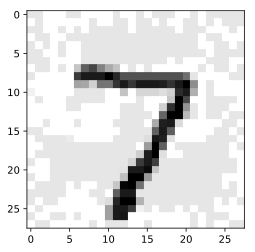

In [169]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

### Certifying robustness

If we want to determine, _exactly_, whether any adversarial example exists for a given example and , we can simply run the integer programming solution using a targeted attack for every possible alternative class label.   If any of these optimization objectives have a negative solution, then there exists and adversarial example, and the optimization formulation provides it for us.  In contrast, if none of the optimization objectives is negative for _any_ target class, then the classifier has been _formally certified_ to be robust on this example.  Let's see how to do this to verify that a smaller perturbation ball _cannot_ change the class label.

In [179]:
epsilon = 0.05
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 5.810042236946861
Targeted attack 1 objective: 10.836173372728197
Targeted attack 2 objective: 2.039339255684599
Targeted attack 3 objective: 0.018872730723538567
Targeted attack 4 objective: 13.52836423718531
Targeted attack 5 objective: 5.146072840088203
Targeted attack 6 objective: 20.45439065167794
Targeted attack 8 objective: 3.5428745576535814
Targeted attack 9 objective: 4.274027214275465


All these terms are positive, so there exists _not_ $\ell_\infty$ adversarial perturbation of size $\epsilon=0.05$.  And in the case where there are adverarial examples, the process can also determine which targeted attacks are possible.

In [180]:
epsilon = 0.1
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: -2.545012509042315
Targeted attack 1 objective: 3.043376725812322
Targeted attack 2 objective: -4.966118334049208
Targeted attack 3 objective: -7.309837079755624
Targeted attack 4 objective: 4.741011344284811
Targeted attack 5 objective: -4.870590800081836
Targeted attack 6 objective: 7.980441149609722
Targeted attack 8 objective: -6.9536251954142365
Targeted attack 9 objective: -3.314370640372009


So for example, this tells us there is _no_ $\ell_\infty$ adversarial perturvation of size $\epsilon=0.1$ that can make the classifier predict the image to be a 1.  We can also use this procedure to derive an upper bound on the loss (or an exact solution in the binary case), but we will defer this discussion to the next section when we do a similar thing using convex relaxations.

## Upper bounding the inner maximization (convex relaxations)

**While the exact solution to the inner maximization problem based upon integer programming is valuable (both for small networks and from a pedagogical perspective), the approach does not scale to substantially larger networks.  And this is not merely a matter of needed a bit more compute: these are combinatorial problems that _do_ scale exponentially at some point, so for even modestly-sized networks, it is easy to find problems where the optimization will _never_ finish (e.g. before the heat death of the universe), no matter what computational resources are available.  Because of this, if we want to provide formal guarantees of robustness, it is important to be able to obtain fast _upper bounds_ on the inner maximization problem.  If, for example, we can attain an upper bound which still shows that no targetted attack can change the class label, this also provides a verification that no attack is possible.**

In this section, we are going to present two different approaches to forming an upper bound, one which is based upon a convex relaxation of the integer programming problem (which provides a tighter bound, but which is still relatively expensive to compute for larger networks, albeit no combinatorially so), and one which is based on bound propagation (which is a looser bound, but much faster to compute).

### Convex relaxations of the verification problem

The element of the integer program above, which is what makes the program combinatorially hard to solve, is precisely the binary integer constraint that we introduced to exactly capture the ReLU operator
\begin{equation}
v_i \in \{0,1\}^{|v_i|}.
\end{equation}
This is not a convex set, and hence hard to optimize over.  Importantly, this is the _only_ difficult constraint in the problem; if it were removed, we would have a linear program, for which there exist very fast solution methods.  Thus, if we want to form a _relaxation_ of the above problem, an obvious idea is simply to relax this contraint that each element of $v_i$ must be either zero or one to the constraint that each element just be between zero or one, but allowed to take on fractional values
\begin{equation}
0 \leq v_i \leq 1.
\end{equation}
Other than this change, the entire optimization problem stays the same as it was before.  This is known as a convex relaxation of the integer problem, and we should emphasize that methods for actually solving the MILP are virtually all based upon this strategy, so the solver already did something like this internally at the very beginning of the solution process.  Considered just by itself, though this relaxation has the nice property that, for example, if we solve the relaxed version of a targeted attack problem, and the objective is _still_ positive, we have verified that this attack will not work; the relaxed set is strictly larger than the original set, so if no "adversarial example" exists in the relaxed set, it will not exist in the original set either.

The reason why we put "adversarial example" in quotes now, is that solving the relaxed problem does not actually produce a true adversarial example anymore.  The logic we used above, to construct a set of constraints equivalent to the ReLU, very specifically relied on the fact that $v_i$ had to take on binary values.  Allowing the $v_i$ terms to be fractional-valued essentially means that we can allows the ReLU to be "partially off and partially on".  It turns out there is a very simple way to describe this relaxation visually.  If we consider the original (integer) ReLU constraint, it is essentially a requirement that the pre-ReLU value $(W_i z_i + b_i)_j$ and post-ReLU value $(z_{i+1})_j$ for all $j$, lie within the following "bounded ReLU" set.
![Bounded ReLU set.](bounded_relu.svg)
When we relax $v_i$ to be fractional valued, this turns out to be equivalent (we won't prove this formally, but it's not that hard to show), that this relaxes this bounded ReLU set to its convex hull.
![Convex hull of the bounded ReLU set.](relu_hull.svg)
In other words, the "post-ReLU" values $z_{i+1}$ need not be the actual ReLU of $(W_i z_i + b_i)$: for instance certain pre-ReLU values could be negative, while the corresponding $z_{i+1}$ is positive.  This means that if we take the solution to the convex relaxation, and actually feed it through the network, it likely will _not_ actually achieve the same last layer as found by the network.  Thus, **what is achieved by relaxation is not the construction of adversarial example itself, but rather the objective value of the optimization problem, which can formally certify that _no_ adversarial example exists**.  By the nature of the outer bound, there may of course be a setting where there is no adversarial example, yet the relaxation fails to certify it: that is, by violating the actual ReLU constraints, the relaxation is able to construct an example with a negative objective, even though no actual example could achieve this.  And indeed, as we will see shortly, for networks trained in a standard fashion, the bound is quite loose; but what will be interesting is that for networks specifically trained to minimize these upper bounds, we often _can_ provide non-trivial guarantees about the robustness of the resulting classifiers.

Here is another way to view what is happening.  When we "feed" the $\ell_\infty$ norm ball through a deep network, the result at the last layer of network (as set known as the _adversarial polytope_) is a nasty, non-convex set.
![Norm-bounded input, and resulting adversarial polytope.](adversarial_polytope.svg)
Finding the a worst-case point in this set (a point that moves as much in the direction that maximizes the target class logit and minimizes the true class logit) is precisely what the MILP we described above does.  But when we take the convex relaxation of this set, we are effectively consider an _convex outer bound_ on the adversarial polytope.
![Convex outer bound on the adversarial polytope](adversarial_outer.svg)
This set is easier to optimize over (since it is convex), and it is a strictly larger set, so if no adversarial example exists in the larger set, then none exists in the true adversarial polytope either.  The outer bound can of course be quite loose in some settings, but for larger networks these are virtually the only strategy available to get strong guarantees about the robustness of deep classifiers.

Let's see what how this convex relaxation works in practice.  For now, we're going to use the exact same code as we did for the integer programming formulation, but simply relax $v_i$ from being a binary variable to being constrained betwen zero and one.

In [182]:
def form_lp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i]),
                        v[i] >= 0,
                        v[i] <= 1]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

Let's run this on the same example as we did for the integer programming solution, and see how the two bounds compare.

In [186]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.eye(10)[y[0].item()] - np.eye(10)[2]

prob, (z, v) = form_lp(model_small, c, initial_bound, bounds)
print("Objective value:", prob.solve(solver=cp.GUROBI))
print("Last layer from relaxation:", z[3].value)

Objective value: -26.119774634225454
Last layer from relaxation: [-0.54239629 -3.68197597 21.97748102  6.17979398 -6.16385997 -0.27719886
 -2.25631931 -4.14229362  9.61796699 -5.31716916]


So our relaxtion believes that we can make the class 2 logit 26.1198 larger than the true label, the class 7 logit.  If you inspect the output of the previous integer programming solution, you'll note that this -26.1198 value appears in the first line of solver progress.  This is because the initial bound that Gurobi generates when solving the integer program is precisely the solution to this relaxation.  And like the integer programming solution, there is also an initial perturbation that is determined by the optimization algorithm.

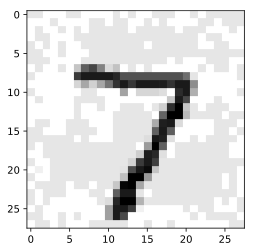

In [187]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

Unlike the integer programming case, however, if we actually feed this perturbation through the network, it does not produce the same activations as what the relaxation predicts (although we should point out that in this case, it _does_ still produce an adversarial example).

In [189]:
print("Last layer from model:", 
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [ 1.1390655 -2.760746   8.2507715  5.9955297 -5.9659457  0.492265
 -8.71024    3.8318188  6.594626  -1.3704427]


As a last example, let's use this procedure to verify the robustness of a network to some very small perturbation.  Again, this is the same code as before, just calling the convex relaxation instead of the integer program.

In [198]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 8.679119731697458
Targeted attack 1 objective: 12.233313266959202
Targeted attack 2 objective: 4.120827654631229
Targeted attack 3 objective: 1.857739424985871
Targeted attack 4 objective: 16.236514322580383
Targeted attack 5 objective: 7.964241745873003
Targeted attack 6 objective: 23.459304334257965
Targeted attack 8 objective: 6.10314963105955
Targeted attack 9 objective: 5.581247281946292


So we are able to verify that _no_ $\ell_\infty$ perturbation of size $\epsilon=0.02$ will fool this classifier.  And unlike the integer program, we can actually call this procedure on the larger models (which will not produce a solution for the exact integer program).  Here it is running on the 4-layer DNN we used above, which the integer programming approach cannot solve.

In [197]:
epsilon = 0.01
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_dnn_4, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_dnn_4, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 5.480101103982182
Targeted attack 1 objective: 2.196709825912893
Targeted attack 2 objective: 0.4646296745679468
Targeted attack 3 objective: -2.264958127925656
Targeted attack 4 objective: 9.8073503196978
Targeted attack 5 objective: 1.4951834763453595
Targeted attack 6 objective: 12.835283301376197
Targeted attack 8 objective: -0.39325769328255866
Targeted attack 9 objective: -1.9890586254866953


### Faster solutions of the convex relaxation

Although the convex relaxation we presented here was billed as being "fast" compared to the "slow" integer program, let's qualify these terms.  The above code, for verifying a _single_ MNIST example, ran in a few seconds on our machine.  If we want to actually verify _all_ the MNIST examples, and perhaps on slightly larger models, this is still not particularly feasible.

Due to this fact, most of the research work focused on convex relaxation approaches to verification are actually based upon methods for _quickly solving_ (possibly approximately, but ideally in a manner that still gives guarantees), the convex relaxations.  The details are beyond the scope of this tutorial, but it turns out that using a procedure known as convex duality, plus some manipulation of the optimization problem, we can quickly compute a provable lower bound on the relaxed objective (which in turn gives an even "looser" relaxation of the original problem) **using a single backward pass through the network**.  This is fast enough that we can even use the procedure to compute tighter interval bounds than the simple bound propagation we described earlier.  However, finding the right trade-offs between complexity of the verification procedure and tightness of the bounds is still an open research question, and no truly scalable solution (that is, a procedure that is both computationally efficient _and_ which provides tight bounds for truly large-scale networks) has been found yet.


### Interval-propagation-based bounds

Before moving on, we want to present one last approach for upper bounding the inner optimization problem, based more directly on the techniques for bound propagation that we discussed earlier.  These bounds are weaker than those based on the convex relaxation, and they do not provide even a "fake" adversarial example like the convex relaxation approaches, but they have the advantage that they are **extremely efficient**.  Recent work in fact suggests that when it comes to training robust networks (the topic we will discuss extensively in the next chapter), it is more worthwhile to use these bound propagation techniques (potentially with a more complex network), than it is to use a simpler network and the tigher but more costly bounds based upon convex relaxtions.  But a full comparison of the two approaches still remains a topic of active research.

Let's return to the method we discussed previously on propagating interval bounds through the newtork.  Specifically, given some bounds $\hat{l} \leq z \leq \hat{u}$, we know that
\begin{equation}
l \leq Wx + b \leq u
\end{equation}
where
\begin{equation}
\begin{split}
l & = \max\{W,0\} \hat{l} + \min\{W,0\} \hat{u} + b \\
u & = \max\{W,0\} \hat{u} + \min\{W,0\}\hat{l} + b.
\end{split}
\end{equation}
Thus, these bounds effectively _by themselves_ also give bounds on the allowable values we can achieve in the network.  However, propagating these bounds through to the _very last_ layer is wasteful, because we know we are ultimately trying to minimize some specific linear function of the last layer.  Thus, what we can do instead is propagate these bounds to the second-to-last layer, and then analytically solve the minimization problem at the last layer.

A bit more concretely, for a $d$-layer network our goal as we saw above was to minimize some linear function of the last layer $c^T z_{d+1}$.  If we have an interval bound on the second-to-last layer $\hat{l} \leq z_d \leq \hat{u}$, then we can simply solve the optimization problem
\begin{equation}
\begin{split}
\minimize_{z_d,z_{d+1}} \;\; & c^T z_{d+1} \\
\subjectto \;\; & z_{d+1} = W_d z_d + b_d \\
& \hat{l} \leq z_d \leq \hat{u}.
\end{split}
\end{equation}
But this problem has an easy analytical solution, based upon the same strategy we used for computing the bounds before.  Specifically, if we just eliminate the $z_{d+1}$ variable using the first constraint, this problem is equivalent to
\begin{equation}
\begin{split}
\minimize_{z_d} \;\; & c^T (W_d z_d + b_d) \equiv (W_d^T c)^T z_d + c^T b_d \\
\subjectto \;\; & \hat{l} \leq z_d \leq \hat{u}.
\end{split}
\end{equation}
This is the problem of minimizing a linear function subject to bound constraints, which was exactly the task we had before.  The analytic solution is just to choose $(z_d)_j = \hat{l}_j$ if $(W_d^T c)_j > 0$, and $(z_d)_j = \hat{u}_j$ otherwise.  This results in the optimal objective value
\begin{equation}
\max\{c^T W_d c,0\} \hat{l} + \min\{c^T W_d,0\} \hat{u} + c^T b_d
\end{equation}
Let's see what this looks like, combined with our previous bound propagation method.  Note that one very nice this about this is that we easily write this code to compute the bounds simultaneously for multiple values of $c$ (which we want to do to consider all targetted attacks), and for multiple examples in a minibatch.

In [218]:
def interval_based_bound(model, c, bounds):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l.t() + cW.clamp(max=0) @ u.t() + cb[:,None]).t()    

Let's apply this bound to the same $\epsilon=0.02$ that we were able to certify using the convex relaxation.

In [221]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
C = -torch.eye(10).to(device)
C[y[0].item(),:] += 1

print(interval_based_bound(model_small, C, bounds).detach().cpu().numpy())

[[ -7.426559   -2.0292485  -8.31501   -15.399408    2.3813596 -10.803006
    5.575859    0.        -13.850781  -11.277755 ]]


The entries here are lower bounds on the optimization objective for each target class (notice the entry for the target class 7, which is the true class, is zero, as $c=0$ in that case).  These are, as expected, substantially looser bounds than we get when solving even the convex relaxation optimization problem. Unlike the convex relaxation, there is no "single" input (even with relaxed activations) that creates these bounds on the logit differences: each individual activation assumes that the previous layer could take on a _separate_ set of values to minimize or maximize just that one activation.  But these bounds have the distinct advantage that they are incredibly fast to compute _and_ are already fully implemented within PyTorch, meaning we can backpropagate through them to actually train the network based on a robust criterion.  This will be discussed at length in the next chapter.

## Summary

We covered a lot of ground in this chapter, but the thing to keep in mind through all of this is that fundamentally, these approaches are all different methods for optimizing (approximately or otherwise) the inner optimization problem of the adversarial robustness objective (or, in some cases, optimizing a linear function of the last level logits, which is effectively the same thing).  In some cases this gives us an actual attack perturbation (indeed, this is often viewed as the whole point of the inner optimization), but in other cases it merely provided a bound on the optimization objective, useful for provably verifying (and later, for training) robust classifiers.  Importantly, we hope that it helped to convey the nature of the inner optimization problem beyond just heuristics for approximately optimizing it in practice: the nature of this optimization problem goes well beyond just the task of finding adversarial examples, and this should be emphasized when discussion adversarial robustness.